In [1]:
import math
from typing import List
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import string
import spacy

warnings.filterwarnings(action='ignore', category=RuntimeWarning)

In [14]:
def plot_surprisals(words:List[str], surprisals_df):
    num_words = len(words)
    cols = min(num_words, 3)
    rows = math.ceil(num_words / cols)

    plt.style.use('ggplot')
    fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    axs = np.atleast_2d(axs)

    for i, word in enumerate(words):   
        word_data = surprisals_df[surprisals_df['Token'] == word].iloc[1:]  # mention this
        if word_data.empty:
            print(f'No data found for the word "{word}"')
            continue

        ax = axs[i//cols, i%cols]
        ax.plot(word_data['Steps'], word_data['MeanSurprisal'], marker='o')
        ax.set_title(f'"{word}"')
        ax.set_xlabel('BERT steps (log10)')
        ax.set_ylabel('Mean surprisal')
        ax.set_xscale('log')
        ax.invert_yaxis()

    # Remove empty subplots
    for j in range(i+1, rows*cols):
        fig.delaxes(axs.flatten()[j])

    plt.tight_layout()
    plt.show()


In [15]:
wikitext_surprisals = 'sample_data/wikitext/bert_surprisals_large.txt'
chang_bergen_surprisals = 'r_code/tacl_data/lm_data/bert_surprisals.txt'
surprisals = pd.read_csv(wikitext_surprisals, delimiter='\t')

In [16]:
surprisals = (surprisals
    .sort_values(['Token', 'Steps'])
    .groupby('Token')
    .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0), 
                              StdevSurprisalDiff = x['StdevSurprisal'].diff().fillna(0)))
    .reset_index(drop=True))

surprisals.insert(0, 'Token', surprisals.pop('Token'))
surprisals = surprisals[surprisals['Token'].apply(lambda t: t.isascii() and not t.isdigit())]
surprisals

/tmp/ipykernel_1687500/3822632482.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.assign(MeanSurprisalDiff = x['MeanSurprisal'].diff().fillna(0),


,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff
522,100th,0,8265,14.729807,0.114784,0.0,2,0.000000,0.000000
523,100th,20000,10,6.275679,0.571626,0.0,2,-8.454128,0.456843
524,100th,40000,14,7.686354,0.907284,0.0,2,1.410675,0.335658
525,100th,60000,5,6.205370,1.967315,0.0,2,-1.480984,1.060031
526,100th,80000,2,5.086202,1.475961,0.0,2,-1.119168,-0.491355
...,...,...,...,...,...,...,...,...,...
284282,zu,1600000,0,2.632001,3.066978,0.5,4,-0.153028,-0.168203
284283,zu,1700000,0,2.860503,3.312823,0.5,4,0.228502,0.245846
284284,zu,1800000,0,2.903762,3.357431,0.5,4,0.043259,0.044608
284285,zu,1900000,0,2.735918,3.165675,0.5,4,-0.167844,-0.191756


In [17]:
surprisals['Token'].nunique()

9239

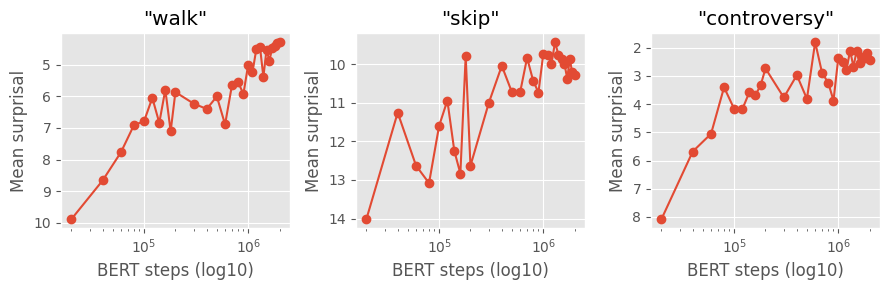

In [31]:
import random

random_1 = random.choice(surprisals['Token'].unique().tolist())
random_2 = random.choice(surprisals['Token'].unique().tolist())
plot_surprisals(['walk', random_1, random_2], surprisals)

### Most vs least frequent words

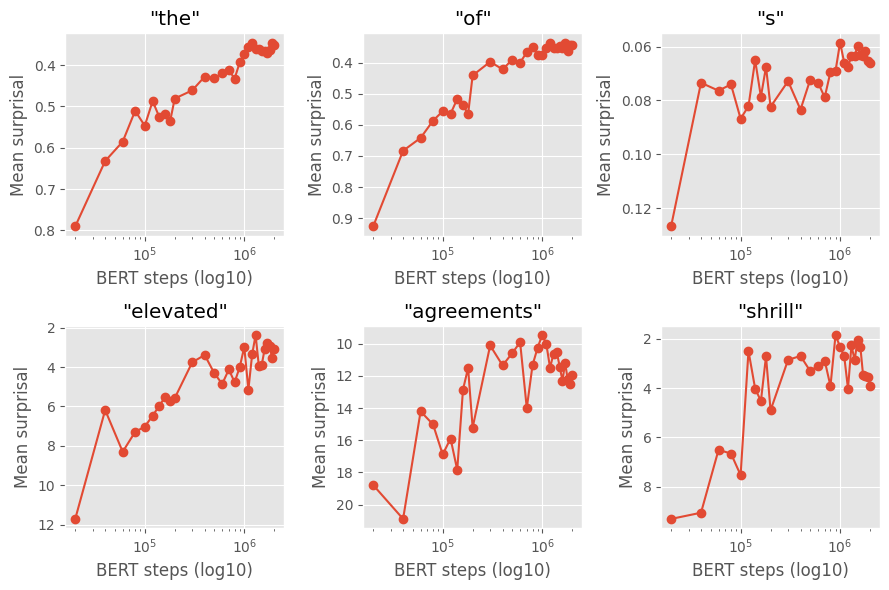

In [19]:
frequent = surprisals[surprisals['NumExamples'] == 512]
infrequent = surprisals[surprisals['NumExamples'] == 1]

plot_surprisals(
    frequent['Token'].drop_duplicates().sample(3).tolist() + infrequent['Token'].drop_duplicates().sample(3).tolist(), 
    surprisals
    )

### Corpus-level surprisals 

(9.128148020530055, 4.911614244446303)

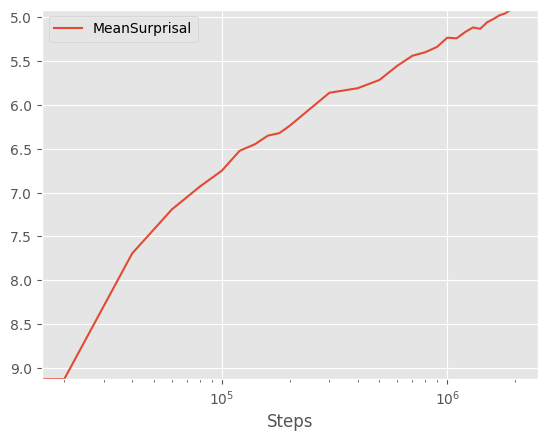

In [21]:
# for each step, average surprisal across all words

avg_surprisals = surprisals.groupby('Steps')['MeanSurprisal'].mean().reset_index()
avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(avg_surprisals['MeanSurprisal'].iloc[1:].max(), avg_surprisals['MeanSurprisal'].min())

Min surprisal: 0.6945541321765631
Max surprisal (excluding the first step): 1.824401656165719
Average variability (excluding the first step): -0.041774945385340184


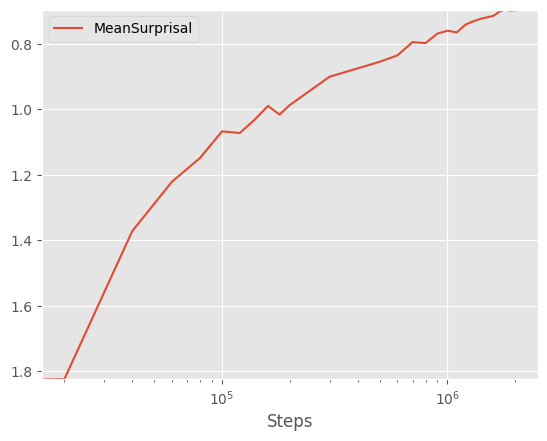

In [22]:
# for each step, average surprisal across all words with at least 512 examples (frequent words)

avg_freq_surprisals = frequent.groupby('Steps')['MeanSurprisal'].mean().reset_index().assign(Diffs=lambda x: x['MeanSurprisal'].diff().fillna(0))

avg_freq_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(avg_freq_surprisals['MeanSurprisal'].iloc[1:].max(), avg_freq_surprisals['MeanSurprisal'].min())

print(f"Min surprisal: {avg_freq_surprisals['MeanSurprisal'].min()}")
print(f"Max surprisal (excluding the first step): {avg_freq_surprisals['MeanSurprisal'].iloc[1:].max()}")
print(f"Average variability (excluding the first step): {avg_freq_surprisals['Diffs'].iloc[2:].mean()}")

Min surprisal: 6.088047743923994
Max surprisal (excluding the first step): 10.854517140057967
Average variability (excluding the first step): -0.17653590356051752


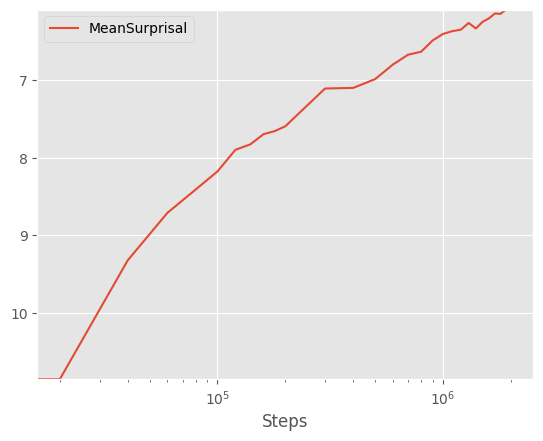

In [23]:
# for each step, average surprisal across all words with exactly 8 examples (infrequent words)

avg_infreq_surprisals = infrequent.groupby('Steps')['MeanSurprisal'].mean().reset_index().assign(Diffs=lambda x: x['MeanSurprisal'].diff().fillna(0))

avg_infreq_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(avg_infreq_surprisals['MeanSurprisal'].iloc[1:].max(), avg_infreq_surprisals['MeanSurprisal'].min())

print(f"Min surprisal: {avg_infreq_surprisals['MeanSurprisal'].min()}")
print(f"Max surprisal (excluding the first step): {avg_infreq_surprisals['MeanSurprisal'].iloc[1:].max()}")
print(f"Average variability (excluding the first step): {avg_infreq_surprisals['Diffs'].iloc[2:].mean()}")

In [13]:
# plot_surprisals(bert_surprisals['Token'].drop_duplicates().tolist(), bert_surprisals)

### Words with different POS

In [23]:
def get_pos_tags(doc_path):
    nlp = spacy.load('en_core_web_sm')
    nlp.max_length = 2000000
    pos_dict = {}
    with open(doc_path, 'r', encoding='utf-8') as file:
        text = file.read()
        doc = nlp(text)
        for token in doc:
            if token.text in pos_dict and not token.pos_ in pos_dict[token.text]:
                pos_dict[token.text].append(token.pos_)
            else:
                pos_dict[token.text] = [token.pos_]
        
    return pd.DataFrame(list(pos_dict.items()), columns=['Token', 'POS'])

In [24]:
document = "sample_data/wikitext/wikitext103_test.txt"
pos_tags = get_pos_tags(document)
pos_tags

,Token,POS
0,,[SPACE]
1,Robert,[PROPN]
2,Boulter,[PROPN]
3,is,[AUX]
4,an,[DET]
...,...,...
20889,Author,[NOUN]
20890,credibility,[NOUN]
20891,Ronnie,[PROPN]
20892,Pelkey,[PROPN]


In [26]:
merged_df = pd.merge(surprisals, pos_tags, on='Token', how='inner')
merged_df

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
0,0,0,5430,14.465205,0.449287,0.000000,54,0.000000,0.000000,[NUM]
1,0,20000,9,5.236457,2.585213,0.185185,54,-9.228748,2.135925,[NUM]
2,0,40000,6,5.139401,2.837999,0.148148,54,-0.097056,0.252786,[NUM]
3,0,60000,7,5.123198,2.672003,0.166667,54,-0.016203,-0.165997,[NUM]
4,0,80000,5,5.086898,2.730958,0.222222,54,-0.036299,0.058956,[NUM]
...,...,...,...,...,...,...,...,...,...,...
74148,’,1600000,1,3.275542,2.447422,0.315789,19,-0.030489,-0.044761,[PUNCT]
74149,’,1700000,1,3.338722,2.574293,0.315789,19,0.063179,0.126871,[PUNCT]
74150,’,1800000,1,3.191885,2.400538,0.315789,19,-0.146837,-0.173755,[PUNCT]
74151,’,1900000,1,3.282053,2.490893,0.315789,19,0.090168,0.090355,[PUNCT]


In [29]:
all_pos_tags = [pos for pos_list in merged_df['POS'] if isinstance(pos_list, list) for pos in pos_list]
set(all_pos_tags)

{'ADJ',
 'ADP',
 'ADV',
 'AUX',
 'CCONJ',
 'DET',
 'INTJ',
 'NOUN',
 'NUM',
 'PART',
 'PRON',
 'PROPN',
 'PUNCT',
 'SCONJ',
 'SYM',
 'VERB',
 'X'}

In [30]:
num_nouns = merged_df[merged_df['POS'].apply(lambda pos_list: 'NOUN' in pos_list)]['Token'].nunique()
num_verbs = merged_df[merged_df['POS'].apply(lambda pos_list: 'VERB' in pos_list)]['Token'].nunique()
num_adjs = merged_df[merged_df['POS'].apply(lambda pos_list: 'ADJ' in pos_list)]['Token'].nunique()
num_advs = merged_df[merged_df['POS'].apply(lambda pos_list: 'ADV' in pos_list)]['Token'].nunique()

print(f"Total number of nouns: {num_nouns}")
print(f"Total number of verbs: {num_verbs}")
print(f"Total number of adjectives: {num_adjs}")
print(f"Total number of adverbs: {num_advs}")

Total number of nouns: 1153
Total number of verbs: 631
Total number of adjectives: 359
Total number of adverbs: 142


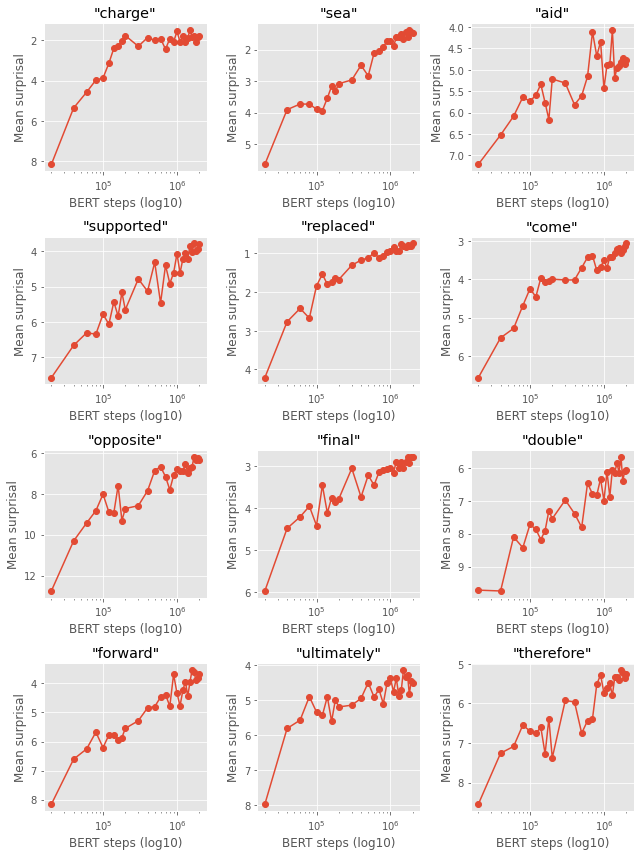

In [32]:
exclusive_noun = merged_df[merged_df['POS'].apply(lambda pos_list: 'NOUN' in pos_list and 'VERB' not in pos_list)]
exclusive_verb = merged_df[merged_df['POS'].apply(lambda pos_list: 'VERB' in pos_list and 'NOUN' not in pos_list)]
adj = merged_df[merged_df['POS'].apply(lambda pos_list: 'ADJ' in pos_list)]
adv = merged_df[merged_df['POS'].apply(lambda pos_list: 'ADV' in pos_list)]

noun_sample = exclusive_noun['Token'].drop_duplicates().sample(3).tolist()
verb_sample = exclusive_verb['Token'].drop_duplicates().sample(3).tolist()
adj_sample = adj['Token'].drop_duplicates().sample(3).tolist()
adv_sample = adv['Token'].drop_duplicates().sample(3).tolist()

plot_surprisals(
    noun_sample + verb_sample + adj_sample + adv_sample, 
    merged_df
    )

(7.049405028359629, 3.3670890146690393)

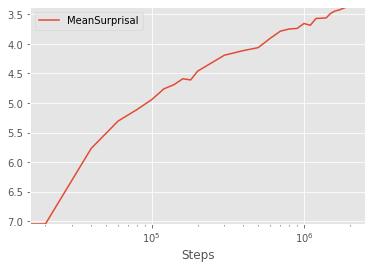

In [33]:
# for each step, average surprisal across all words with 'NN' tag (Noun, singular or mass)

N_avg_surprisals = exclusive_noun.groupby('Steps')['MeanSurprisal'].mean().reset_index()
N_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(N_avg_surprisals['MeanSurprisal'].iloc[1:].max(), N_avg_surprisals['MeanSurprisal'].min())

(6.669556319508413, 3.2502232579940773)

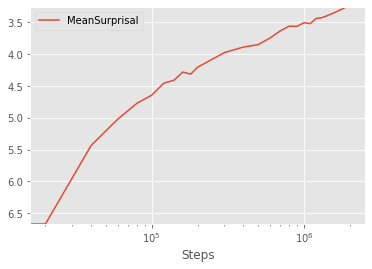

In [34]:
# for each step, average surprisal across all words with 'VB' tag (Verb, base form)

VB_avg_surprisals = exclusive_verb.groupby('Steps')['MeanSurprisal'].mean().reset_index()
VB_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(VB_avg_surprisals['MeanSurprisal'].iloc[1:].max(), VB_avg_surprisals['MeanSurprisal'].min())

(7.368662540294998, 3.9876339144195354)

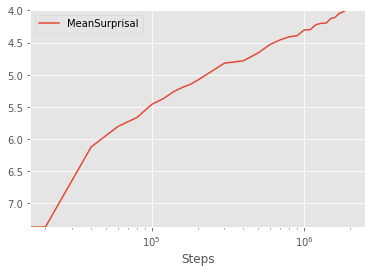

In [35]:
# for each step, average surprisal across all words with 'JJ' tag (Adjective)

adj_avg_surprisals = adj.groupby('Steps')['MeanSurprisal'].mean().reset_index()
adj_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(adj_avg_surprisals['MeanSurprisal'].iloc[1:].max(), adj_avg_surprisals['MeanSurprisal'].min())

(6.897745552197309, 3.8908464171936816)

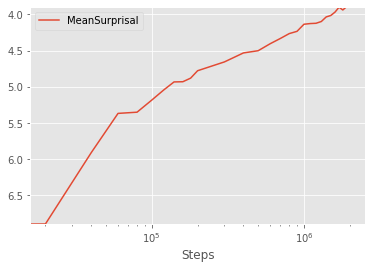

In [36]:
# for each step, average surprisal across all words with 'RB' tag (Adverb)

adv_avg_surprisals = adv.groupby('Steps')['MeanSurprisal'].mean().reset_index()
adv_avg_surprisals.plot(x='Steps', y='MeanSurprisal', logx=True)\
    .set_ylim(adv_avg_surprisals['MeanSurprisal'].iloc[1:].max(), adv_avg_surprisals['MeanSurprisal'].min())

### Top 5 largest and smallest absolute diffs

In [37]:
largest_abs_diffs = merged_df.loc[merged_df['MeanSurprisalDiff'].abs().nlargest(5).index]
largest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
43762,mph,20000,0,0.797571,0.862313,0.722222,36,-15.885048,0.484566,[NOUN]
57769,s,20000,0,0.138155,0.787840,0.986328,512,-15.667567,0.376284,[PART]
40195,los,20000,0,0.978007,2.024460,0.807692,26,-15.329066,1.568838,[PROPN]
66614,the,20000,0,0.774229,1.201693,0.869141,512,-15.259229,0.818221,[DET]
42254,metres,20000,0,1.124400,2.373496,0.807692,26,-14.982680,1.939764,[NOUN]


In [38]:
smallest_abs_diffs = merged_df[merged_df['Steps'] != 0].sort_values(by='MeanSurprisalDiff', key=abs).head(5)
smallest_abs_diffs

,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
26554,ex,1100000,0,2.280322,4.523910,0.760000,25,0.000009,-0.041249,[NOUN]
6465,ad,1900000,0,1.784674,2.337420,0.500000,20,-0.000019,0.060032,[X]
54671,references,120000,0,3.665914,3.650630,0.600000,10,0.000019,0.009496,[NOUN]
46747,operating,2000000,1,3.268388,3.624349,0.416667,12,-0.000024,0.200978,[VERB]
8420,animal,200000,19,9.230306,7.028107,0.300000,10,0.000034,-0.208739,[NOUN]


In [137]:
# for each time step, look for the n largest and n smallest

In [39]:
largest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nlargest(5, 'MeanSurprisalDiff'))
largest_diffs[largest_diffs['Steps'] != 0]

Token    Steps  MedianRank  MeanSurprisal  \
Steps                                                            
20000   2901           209    20000        4914      16.741354   
        30306      formula    20000        4090      16.690645   
        43066     monitors    20000         474      14.715742   
        36628  interaction    20000        1261      14.352000   
        71370      warrior    20000         859      14.269057   
...                    ...      ...         ...            ...   
2000000 61305       skulls  2000000           3       3.867877   
        19371    convinced  2000000           4       4.576949   
        57361      roughly  2000000           6       5.510572   
        9395        armies  2000000           5       6.061716   
        66322  temporarily  2000000          18       7.256451   

               StdevSurprisal  Accuracy  NumExamples  MeanSurprisalDiff  \
Steps                                                                     
20000   2901         7.204643  0.111111            9           1.942616   
        30306        1.768035  0.000000           14           1.902834   
        43066        5.750803  0.000000            8          -0.149244   
        36628        2.996786  0.000000            8          -0.518872   
        71370        3.879209  0.000000           11          -0.708079   
...                       ...       ...          ...                ...   
2000000 61305        2.639338  0.125000            8           0.444077   
        19371        2.496498  0.222222            9           0.435923   
        57361        3.404620  0.111111            9           0.417538   
        9395         3.772197  0.111111            9           0.393182   
        66322        2.639702  0.000000            9           0.392465   

               StdevSurprisalDiff          POS  
Steps                                           
20000   2901             6.633651        [NUM]  
        30306            1.343078       [NOUN]  
        43066            5.453446       [NOUN]  
        36628            2.683065       [NOUN]  
        71370            3.598189       [NOUN]  
...                           ...          ...  
2000000 61305            0.026416       [NOUN]  
        19371            0.051803  [VERB, ADJ]  
        57361            0.111656        [ADV]  
        9395            -0.022187       [NOUN]  
        66322            0.033360        [ADV]  

[140 rows x 10 columns]

In [40]:
smallest_diffs = merged_df.groupby('Steps').apply(lambda df: df.nsmallest(5, 'MeanSurprisalDiff'))
smallest_diffs[smallest_diffs['Steps'] != 0]

Token    Steps  MedianRank  MeanSurprisal  \
Steps                                                              
20000   43762            mph    20000           0       0.797571   
        57769              s    20000           0       0.138155   
        40195            los    20000           0       0.978007   
        66614            the    20000           0       0.774229   
        42254         metres    20000           0       1.124400   
...                      ...      ...         ...            ...   
2000000 31986      gradually  2000000           2       3.119752   
        74065              ¥  2000000           5       9.416652   
        64002  strengthening  2000000           1       5.907737   
        63393         status  2000000           0       2.571366   
        13716       bringing  2000000           3       3.672070   

               StdevSurprisal  Accuracy  NumExamples  MeanSurprisalDiff  \
Steps                                                                     
20000   43762        0.862313  0.722222           36         -15.885048   
        57769        0.787840  0.986328          512         -15.667567   
        40195        2.024460  0.807692           26         -15.329066   
        66614        1.201693  0.869141          512         -15.259229   
        42254        2.373496  0.807692           26         -14.982680   
...                       ...       ...          ...                ...   
2000000 31986        1.818251  0.222222            9          -0.590018   
        74065        3.252282  0.000000            9          -0.561500   
        64002        5.022387  0.125000            8          -0.473039   
        63393        2.494640  0.615385           26          -0.463539   
        13716        2.573303  0.250000            8          -0.419208   

               StdevSurprisalDiff           POS  
Steps                                            
20000   43762            0.484566        [NOUN]  
        57769            0.376284        [PART]  
        40195            1.568838       [PROPN]  
        66614            0.818221         [DET]  
        42254            1.939764        [NOUN]  
...                           ...           ...  
2000000 31986           -0.140322         [ADV]  
        74065           -0.083672  [PROPN, SYM]  
        64002            0.015452  [VERB, NOUN]  
        63393            0.121968        [NOUN]  
        13716           -0.263476        [VERB]  

[140 rows x 10 columns]

In [41]:
largest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nlargest(1).index])
largest_abs_diffs[largest_abs_diffs['Steps'] != 0]

,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,43762,mph,20000,0,0.797571,0.862313,0.722222,36,-15.885048,0.484566,[NOUN]
40000,16184,circulation,40000,2,5.923705,3.356577,0.100000,10,-5.580374,-0.845718,[NOUN]
60000,65079,summers,60000,0,2.483058,2.865384,0.666667,9,-3.303980,-1.823587,[NOUN]
80000,30396,fought,80000,1,3.192194,2.855375,0.454545,11,-2.700883,-0.979990,[VERB]
100000,34573,hp,100000,0,1.407464,0.910231,1.000000,8,-2.928402,-1.878764,"[NOUN, NUM]"
120000,43071,monitors,120000,41,9.687982,5.521992,0.250000,8,-3.977440,1.014060,[NOUN]
140000,14014,bulge,140000,476,13.224987,5.790131,0.076923,13,2.952599,-1.174355,[PROPN]
160000,61285,skulls,160000,1,4.281702,2.254530,0.125000,8,-2.482903,0.676927,[NOUN]
180000,70102,values,180000,17,8.485182,1.508637,0.000000,8,3.213609,-1.050251,[NOUN]


In [42]:
smallest_abs_diffs = merged_df.groupby('Steps').apply(lambda df: df.loc[df['MeanSurprisalDiff'].abs().nsmallest(1).index])
smallest_abs_diffs[smallest_abs_diffs['Steps'] != 0]

,,Token,Steps,MedianRank,MeanSurprisal,StdevSurprisal,Accuracy,NumExamples,MeanSurprisalDiff,StdevSurprisalDiff,POS
Steps,,,,,,,,,,,
20000,43066,monitors,20000,474,14.715742,5.750803,0.000000,8,-0.149244,5.453446,[NOUN]
40000,69428,unit,40000,24,7.539590,4.311277,0.142857,21,0.000298,0.208557,[NOUN]
60000,51884,private,60000,8,6.944635,3.956347,0.117647,17,-0.000854,0.178097,[ADJ]
80000,16389,claimed,80000,3,4.379226,1.781143,0.210526,19,-0.000084,-0.076557,[VERB]
100000,25003,emphasis,100000,0,2.576467,3.344326,0.545455,11,-0.000209,-0.175754,[NOUN]
120000,54671,references,120000,0,3.665914,3.650630,0.600000,10,0.000019,0.009496,[NOUN]
140000,4183,52,140000,13,6.301917,1.638797,0.125000,8,0.001724,-0.026780,[NUM]
160000,72827,with,160000,0,1.726200,2.252359,0.652344,512,-0.000315,-0.012373,[ADP]
180000,12653,big,180000,1,4.840733,4.253277,0.392857,28,0.000429,-0.260141,[ADJ]
